# Imports and data loading

In [1]:
import csv
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import copy

import scanorama
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

set_seed(123)
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite = True

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

In [3]:
anndataset_10k = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_5k = anndata.read(save_path + "pbmc_5k_protein_v3.h5ad")

In [4]:
mutual_names = anndataset_10k.var_names.intersection(anndataset_5k.var_names)
anndataset_10k = anndataset_10k[:, mutual_names]
anndataset_5k = anndataset_5k[:, mutual_names]

In [5]:
adata_total = anndata.AnnData.concatenate(anndataset_10k, anndataset_5k)
seurat_v3_highly_variable_genes(adata_total, n_top_genes=4000)
global_high_var_genes = adata_total.var.index[adata_total.var["highly_variable"]]

(15792,)
(6855, 15792)
(15792,)
(3994, 15792)


In [6]:
dataset_10k = AnnDatasetFromAnnData(ad = anndataset_10k[:, global_high_var_genes])
protein_data_10k = CellMeasurement(name="protein_expression", data=anndataset_10k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_10k.uns["protein_names"])
dataset_10k.initialize_cell_measurement(protein_data_10k)

dataset_5k = AnnDatasetFromAnnData(ad = anndataset_5k[:, global_high_var_genes])
protein_data_5k = CellMeasurement(name="protein_expression", data=anndataset_5k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_5k.uns["protein_names"])
dataset_5k.initialize_cell_measurement(protein_data_5k)

[2020-04-24 15:14:53,305] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:14:53,308] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:14:53,364] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:14:53,425] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-04-24 15:14:53,567] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:14:53,569] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:14:53,598] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:14:53,630] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


In [7]:
dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [copy.deepcopy(dataset_10k), copy.deepcopy(dataset_5k)],
    cell_measurement_intersection={"protein_expression": False},
)
batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

[2020-04-24 15:14:54,637] INFO - scvi.dataset.dataset | Keeping 4000 genes
[2020-04-24 15:14:54,727] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:14:54,844] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:14:54,845] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:14:54,900] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-24 15:14:54,955] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:14:54,957] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:14:55,232] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-24 15:14:55,237] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-24 15:14:55,241] INFO - scvi.dataset.dataset | Keeping 29 columns in protein_expression


In [8]:
full_data = dataset.X
norm_full_data = anndata.AnnData(X=full_data)
sc.pp.normalize_per_cell(norm_full_data, counts_per_cell_after=1e4)
sc.pp.log1p(norm_full_data)
norm_full_data = anndata.AnnData(
    X=np.concatenate(
        [
            norm_full_data.X,
            np.log1p(dataset.protein_expression),
        ],
        axis=1,
    )
)
col_names = np.concatenate([dataset.gene_names, dataset.protein_names])
norm_full_data.var_names = col_names

# Create and train models

In [9]:
datasets = [dataset_10k, dataset_5k, dataset]
models = []
trainers = []
names = ["pbmc_10k_harmo_union", "pbmc_5k_harmo_union", "pbmc15k_harmo_union"]

for d in datasets:
    if d.n_batches > 1:
        m = TOTALVI(
            d.nb_genes,
            d.protein_expression.shape[1],
            n_latent=20,
            n_batch=d.n_batches,
            encoder_batch=True,
            protein_batch_mask=batch_mask,
        )
    else:
        m = TOTALVI(d.nb_genes, d.protein_expression.shape[1], n_latent=20)
    models.append(m)
    use_cuda = True
    lr = 4e-3
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 45,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }

    trainer = TotalTrainer(
        m,
        d,
        train_size=0.90,
        test_size=0.10,
        use_cuda=use_cuda,
        frequency=1,
        data_loader_kwargs={"batch_size": 256},
        early_stopping_kwargs=early_stopping_kwargs,
        use_adversarial_loss=True if d.n_batches > 1 else False,
        kappa=None
    )
    trainers.append(trainer)
totalvae_10k, totalvae_5k, totalvae = models[0], models[1], models[2]

In [10]:
if overwrite is True:
    for t, n in zip(trainers, names):
        t.train(lr=lr, n_epochs=500)
        torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")
else:
    for m, n, t in zip(models, names, trainers):
        try:
            m.load_state_dict(torch.load("saved_models/" + n + ".pt"))
            m.eval()
        except FileNotFoundError:
            t.train(lr=lr, n_epochs=500)
            torch.save(t.model.state_dict(), "saved_models/" + n + ".pt")

[2020-04-24 15:23:36,797] INFO - scvi.inference.trainer | Reducing LR on epoch 420.
[2020-04-24 15:24:34,681] INFO - scvi.inference.trainer | Reducing LR on epoch 478.



[2020-04-24 15:28:56,489] INFO - scvi.inference.trainer | Reducing LR on epoch 314.
[2020-04-24 15:30:12,447] INFO - scvi.inference.trainer | Reducing LR on epoch 438.



[2020-04-24 15:40:07,808] INFO - scvi.inference.trainer | Reducing LR on epoch 263.
[2020-04-24 15:43:13,055] INFO - scvi.inference.trainer | Reducing LR on epoch 340.
[2020-04-24 15:45:10,677] INFO - scvi.inference.trainer | Reducing LR on epoch 381.
[2020-04-24 15:49:52,426] INFO - scvi.inference.trainer | Reducing LR on epoch 447.
[2020-04-24 15:51:41,422] INFO - scvi.inference.trainer | Reducing LR on epoch 496.



# Create posteriors

In [11]:
# create posterior on full data
posteriors = []
latents = []
for t, m, d in zip(trainers, models, datasets):
    full_posterior = t.create_posterior(
        m, d, indices=np.arange(len(d)), type_class=TotalPosterior
    )
    posteriors.append(full_posterior)
    # extract latent space
    latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()
    latents.append(latent_mean)

In [15]:
post_adatas = []
if overwrite:
    for n in names:
        os.remove("saved_post_adata/" + n + ".h5ad")
for d, l, n in zip(datasets, latents, names):
    try:
            post_adatas.append(anndata.read_h5ad("saved_post_adata/" + n + ".h5ad"))
    except OSError:
            post_adata = anndata.AnnData(X=d.X)
            post_adata.var.index = d.gene_names
            post_adata.obsm["X_totalVI"] = l
            sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
            sc.tl.umap(post_adata, min_dist=0.2)
            sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.8)
            post_adata.write("saved_post_adata/" + n + ".h5ad", compression="gzip")
            post_adatas.append(post_adata)
d_names = ["PBMC_10k", "PBMC_5k"]
post_adatas[2].obs["batch_indices"] = [d_names[b[0]] for b in datasets[2].batch_indices]

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/p

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical


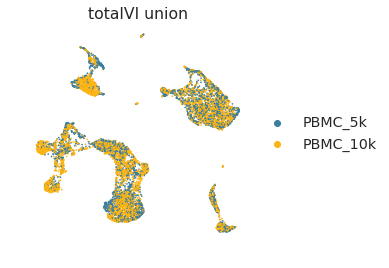

In [16]:
perm_inds = np.random.permutation(len(post_adatas[2]))
fig = sc.pl.umap(
    post_adatas[2][perm_inds], 
    color=["batch_indices"],
    title="totalVI union",
    return_fig=True,
    frameon=False
)
plt.savefig("figures/pbmc_umap_union.pdf", dpi=DPI, bbox_inches="tight")

# Metrics

In [17]:
ENTROPY_K = 100
harmo_metrics = pd.DataFrame(
    index=["totalVI-union"],
    columns=["Local metric", "Mixing metric", "Hotspot metric"],
)
harmo_metrics["models"] = [
    "totalVI-union",
]

harmo_metrics.loc["totalVI-union", "Mixing metric"] = entropy_batch_mixing(
    post_adatas[2].obsm["X_totalVI"], datasets[2].batch_indices.ravel(), n_neighbors=ENTROPY_K
)

0.36814452944971887


In [18]:
subset_features = list(global_high_var_genes) + list(anndataset_10k.uns["protein_names"])

harmo_metrics.loc["totalVI-union", "Hotspot metric"], _, _ = hotspot_score(
    norm_full_data,
    post_adatas[0].obsm["X_totalVI"],
    post_adatas[1].obsm["X_totalVI"],
    post_adatas[2].obsm["X_totalVI"],
    datasets[2].batch_indices.ravel(),
    subset_features=subset_features,
)

100%|██████████| 4014/4014 [00:01<00:00, 3069.26it/s]


6.671184480683362
25.235579475430615


In [19]:
harmo_metrics.to_csv("misc_results/pbmc_union_stats.csv")